In [1]:
import numpy as np
import pandas as pd
import cv2
import os

from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn import metrics

import random

2024-05-15 16:33:41.853669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 16:33:41.853761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 16:33:41.981311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# This cells is made to set the different directories used in this notebook
groups = ['COVID-19', 'Normal', 'Non-COVID']
sets = ['Val', 'Test', 'Train']
# Define base path
base_path = '/kaggle/input/covidqu/Lung Segmentation Data/Lung Segmentation Data' #Chemin jusqu'aux dossiers Test Train Val
destination_path = '/kaggle/working/COVID-EX-Qu-dataset'

In [3]:
# Only run this cell if working files are not in kaggle working directory
import shutil

for sett in sets:
  for group in groups:
    ima_dir = os.path.join(base_path, sett, group)
    for dos in tqdm(os.listdir(ima_dir)):
        if dos=="images":
            shutil.copytree(os.path.join(ima_dir, dos), os.path.join(destination_path, sett, group, dos))

100%|██████████| 2/2 [00:49<00:00, 24.91s/it]


In [4]:
# Checking data integrity after Kaggle input to output directory
n_covid = 0
n_noncovid = 0
n_normal = 0
#----Reference number from COVID-EX-qu Kaggle------------
ref_covid = 11956
ref_noncovid = 11263
ref_normal = 10701
#-------------------------------------------------------
for sett in sets:
  for group in groups:
    ima_dir = os.path.join(destination_path, sett, group)
    for dos in os.listdir(ima_dir):
      num = len(os.listdir(os.path.join(ima_dir, dos)))
      print(f"In the set {sett}, there are {num} {dos} of {group}")
      if group =="COVID-19" and dos=='images':
        n_covid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Non-COVID" and dos=='images':
        n_noncovid += len(os.listdir(os.path.join(ima_dir, dos)))
      if group =="Normal" and dos=='images':
        n_normal += len(os.listdir(os.path.join(ima_dir, dos)))

print(f"\nThere are {n_covid} COVID images found, {n_covid/ref_covid *100}% of the original dataset from Kaggle.")
print(f"There are {n_noncovid} non-COVID images, {n_noncovid/ref_noncovid *100}% of the original dataset from Kaggle.")
print(f"There are {n_normal} normal images, {n_normal/ref_normal *100}% of the original dataset from Kaggle.")

In the set Val, there are 1903 images of COVID-19
In the set Val, there are 1712 images of Normal
In the set Val, there are 1802 images of Non-COVID
In the set Test, there are 2395 images of COVID-19
In the set Test, there are 2140 images of Normal
In the set Test, there are 2253 images of Non-COVID
In the set Train, there are 7658 images of COVID-19
In the set Train, there are 6849 images of Normal
In the set Train, there are 7208 images of Non-COVID

There are 11956 COVID images found, 100.0% of the original dataset from Kaggle.
There are 11263 non-COVID images, 100.0% of the original dataset from Kaggle.
There are 10701 normal images, 100.0% of the original dataset from Kaggle.


In [5]:
# Checking if GPU is activated
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
from tensorflow.keras.applications.xception import preprocess_input # Preprocess for XCeption model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(img):
    '''This function normalizes images by equalizing histograms (grayscale only)'''
    
    # Convert image to grayscale if it's not already
    if len(img.shape) == 3 and img.shape[2] == 3:  # RGB image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ensure image is of type uint8
    img = img.astype('uint8')
    # Equalize histogram
    img = cv2.equalizeHist(img)
    # Convert grayscale back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Preprocess for the model input
    img_preprocessed = preprocess_input(img)
    return img_preprocessed


# Instanciation of image data generators using the preprocessing function defined before

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image) 
val_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_image)

In [7]:
# Preprocessing of each folder

batch_size = 32
train_generator = train_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Train'),
                                                           classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                           class_mode="sparse",
                                                           target_size=(299, 299),
                                                           batch_size=batch_size)

val_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Val'),
                                                        classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                         class_mode="sparse",
                                                         target_size=(299, 299),
                                                         batch_size=batch_size)

test_generator = test_data_generator.flow_from_directory(directory=os.path.join(destination_path, 'Test'),
                                                         classes=['COVID-19', 'Normal', 'Non-COVID'],
                                                          class_mode="sparse",
                                                          target_size=(299, 299),
                                                          batch_size=batch_size, shuffle=False)

nb_img_train = train_generator.samples
nb_img_val = val_generator.samples

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


In [8]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
    
# Initializing Xception model with pre-trained weights, without the specific top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freezing 
for layer in base_model.layers: 
    layer.trainable = False

# Add final layers to the model
XCeption_base = Sequential()
XCeption_base.add(base_model)
XCeption_base.add(GlobalAveragePooling2D())
XCeption_base.add(Dense(512, activation='relu'))
XCeption_base.add(Dropout(rate=0.3))
XCeption_base.add(Dense(256, activation='relu'))
XCeption_base.add(Dropout(rate=0.4))
XCeption_base.add(Dense(3, activation='softmax'))

# Model compilation
XCeption_base.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         mode='min',
                                         restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, #si val_loss stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.01,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 4, # On attend 4 epochs avant de réitérer 
                                    verbose=1)

In [10]:
XCeption_callbacks = XCeption_base
XCeption_callbacks.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
for layer in XCeption_callbacks.layers[0].layers[36:]:
    layer.trainable = True

In [11]:
# Model training - No early stopping as it is messing with the values of val_loss
history_Xception_callbacks = XCeption_callbacks.fit(train_generator, 
                                epochs = 20,
                                steps_per_epoch = nb_img_train//batch_size,
                                validation_data=val_generator,
                                validation_steps=nb_img_val//batch_size,
                                callbacks = [reduce_learning_rate]
                                )

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715791120.199941      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


678/678 ━━━━━━━━━━━━━━━━━━━━ 305s 374ms/step - accuracy: 0.7994 - loss: 0.4952 - val_accuracy: 0.8103 - val_loss: 0.5144 - learning_rate: 0.0010
Epoch 2/20
  1/678 ━━━━━━━━━━━━━━━━━━━━ 3:17 292ms/step - accuracy: 0.8750 - loss: 0.2913

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


678/678 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8750 - loss: 0.2913 - val_accuracy: 0.8889 - val_loss: 0.2122 - learning_rate: 0.0010
Epoch 3/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 223s 327ms/step - accuracy: 0.9111 - loss: 0.2347 - val_accuracy: 0.9227 - val_loss: 0.2101 - learning_rate: 0.0010
Epoch 4/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 0.9062 - loss: 0.2502 - val_accuracy: 1.0000 - val_loss: 0.1457 - learning_rate: 0.0010
Epoch 5/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 222s 326ms/step - accuracy: 0.9317 - loss: 0.1856 - val_accuracy: 0.9007 - val_loss: 0.2507 - learning_rate: 0.0010
Epoch 6/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - accuracy: 0.9688 - loss: 0.0769 - val_accuracy: 1.0000 - val_loss: 0.0623 - learning_rate: 0.0010
Epoch 7/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 223s 327ms/step - accuracy: 0.9424 - loss: 0.1614 - val_accuracy: 0.9201 - val_loss: 0.2084 - learning_rate: 0.0010
Epoch 8/20
678/678 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 0.9688 - loss: 0.119

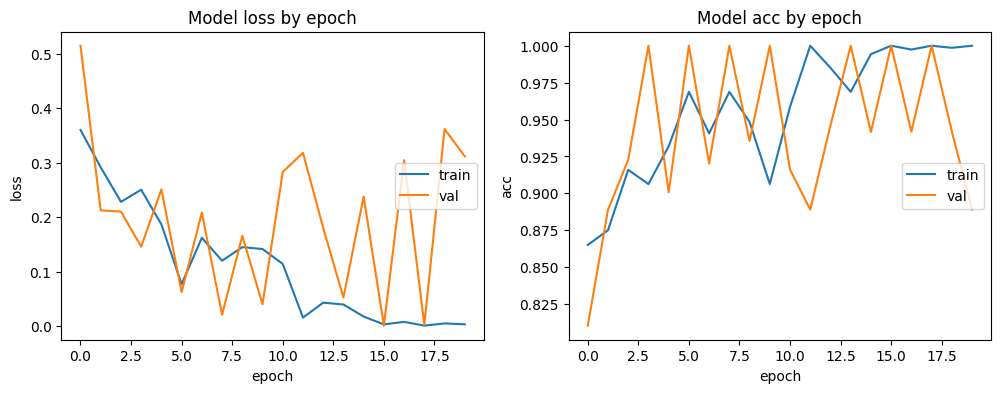

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_Xception_callbacks.history['loss'])
plt.plot(history_Xception_callbacks.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')

plt.subplot(122)
plt.plot(history_Xception_callbacks.history['accuracy'])
plt.plot(history_Xception_callbacks.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='right')
plt.show()

In [13]:
evaluation_callbacks = XCeption_callbacks.evaluate(test_generator)

# Print the evaluation metrics
print("Test Loss:", evaluation_callbacks[0])
print("Test Accuracy:", evaluation_callbacks[1])

213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 153ms/step - accuracy: 0.9796 - loss: 0.1173
Test Loss: 0.2281673401594162
Test Accuracy: 0.9608132243156433


213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 142ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2395
           1       0.92      0.96      0.94      2140
           2       0.97      0.93      0.95      2253

    accuracy                           0.96      6788
   macro avg       0.96      0.96      0.96      6788
weighted avg       0.96      0.96      0.96      6788



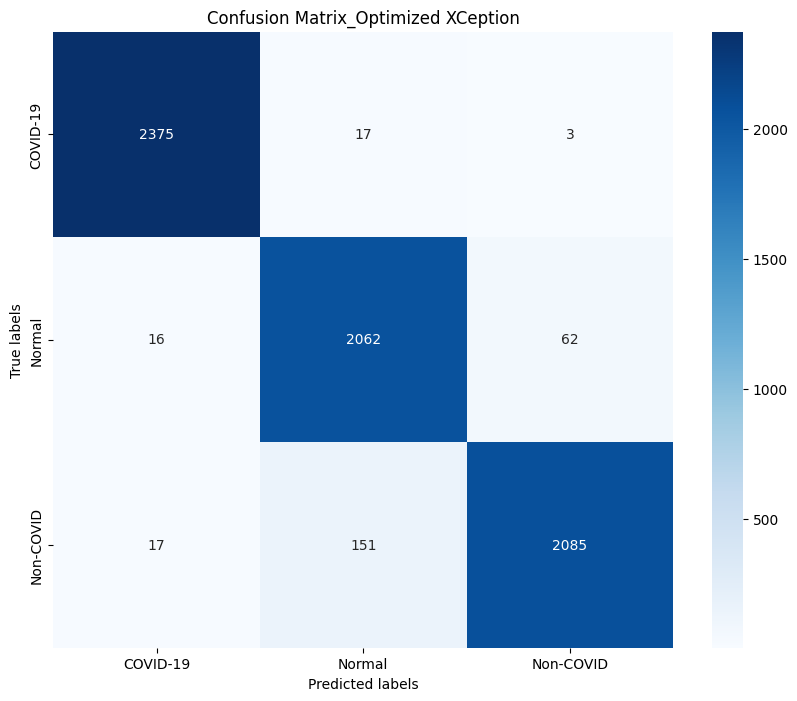

In [14]:
# Confusion_ matrix:

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions on the test data
predictions = XCeption_callbacks.predict(test_generator)
# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)
# Get the true classes
true_classes = test_generator.classes

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(classification_report(true_classes, predicted_classes))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix_Optimized XCeption')
plt.show()

In [15]:
# Visualization of results on images from test_generator data:
class_names = {
    0: 'COVID',
    1: 'Non COVID',
    2: 'Normal'
}

# Function to apply the model on a batch of images and visualize the results
def apply_model_and_visualize_multiple_images(model, data_generator, num_images=12):
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        # Retrieve one image and its label from the generatorl 
        batch_images, batch_labels = random.choice(data_generator)
        image = batch_images[0]  # Take the first image from the batch
        label = round(batch_labels[0])  # Corresponding label
        
        # Reshape the image to (1, height, width, channels) for model prediction
        image = np.expand_dims(image, axis=0)
        
        # Apply the trained model to obtain prediction
        prediction = model.predict(image)
        
        # Round the predicted label to the nearest integer
        predicted_label = np.argmax(prediction)
        
        # Convert integer labels to class names
        true_class_name = class_names[label]
        predicted_class_name = class_names[predicted_label]
        
        # Visualize the result
        plt.subplot(4, 3, i+1)
        plt.imshow(image[0])
        
        # Determine title color based on whether true and predicted labels match
        title_color = 'green' if true_class_name == predicted_class_name else 'red'
        
        plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}", color=title_color)
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


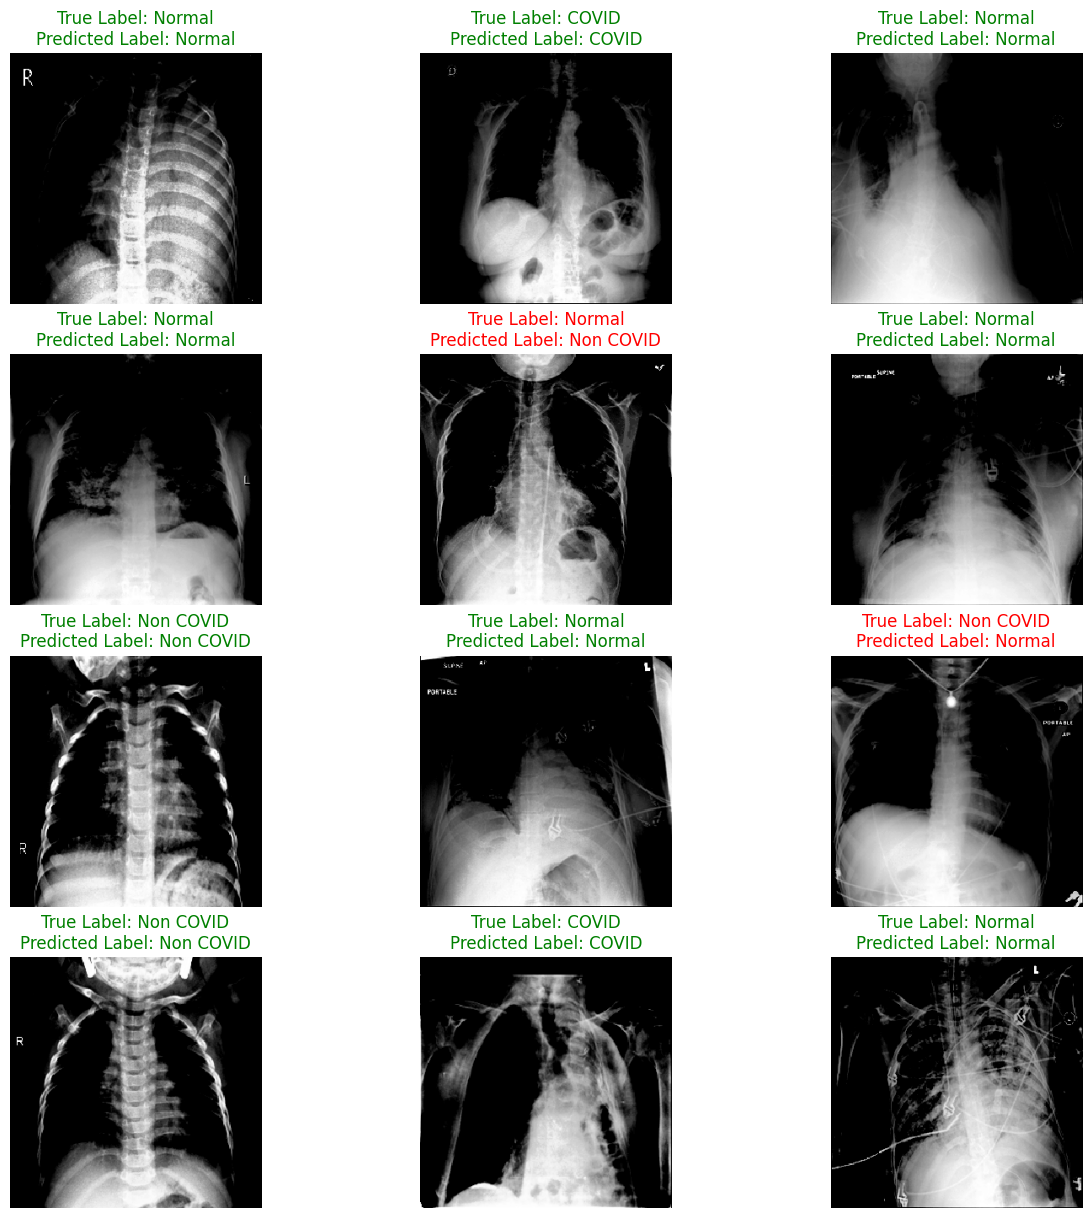

In [16]:
# Example usage for applying the model on multiple images from the validation set
apply_model_and_visualize_multiple_images(XCeption_callbacks, test_generator)
# The images are much more contrasted than they should be with an Histogram Egalization normalization.
# Does the preprocess_input function in Xception apply another normalization on the images which leads to this results ?

In [17]:
# XCeption_callbacks.save("/kaggle/working/Xception_model_96-percent")
# Model seems to save but i still have an error message

In [18]:
# from keras.models import load_model

# # Load the saved model
# loaded_model = load_model("/kaggle/working/Xception_model_96-percent.h5")

# ValueError: Layer 'dense' expected 1 input(s). Received 2 instead.
# There indeed was an error when saving the model, I can't seem to understand the issue